In [1]:
import pyaerocom as pya
import matplotlib.pyplot as plt
import pyaerocom as pya
from pyaerocom.io.readungridded import ReadUngridded
from pyaerocom.io.readgridded import ReadGridded
from pyaerocom.io.helpers_units import (unitconv_sfc_conc_bck, 
                                        unitconv_sfc_conc, 
                                        unitconv_wet_depo_bck,
                                        unitconv_wet_depo, unitconv_wet_depo_from_emep)
import pandas as pd
import numpy as np
from pyaerocom.plot import df_to_heatmap
from pyaerocom import Filter
from pyaerocom.mathutils import calc_statistics 

%matplotlib inline

Initating pyaerocom configuration
Checking database access...
Checking access to: /lustre/storeA
Access to lustre database: True
Init data paths for lustre
Expired time: 0.013 s
/home/hannas/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


{'H': 'hourly', '3H': '3hourly', 'D': 'daily', 'W': 'weekly', 'MS': 'monthly', 'Q': 'season', 'AS': 'yearly'}


/home/hannas/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [99]:
pya.browse_database('*fss*CTRL*')


Pyaerocom ReadGridded
---------------------
Data ID: GFDL-AM4-fSST_AP3-CTRL
Data directory: /lustre/storeA/project/aerocom/aerocom-users-database/AEROCOM-PHASE-III-2019/GFDL-AM4-fSST_AP3-CTRL/renamed
Available experiments: ['AP3-CTRL']
Available years: [2010]
Available frequencies ['monthly' 'daily']
Available variables: ['abs550aer', 'ac550aer', 'airmass', 'areacella', 'cdnc', 'chepsoa', 'clt', 'dh', 'drybc', 'drydust', 'drypoa', 'dryso4', 'drysoa', 'dryss', 'ec550aer', 'emibc', 'emidust', 'emipoa', 'emiso2', 'emiss', 'hur', 'loadbc', 'loaddu', 'loadlgdst', 'loadoc', 'loadsmdst', 'loadso4', 'loadss', 'mmrbc', 'mmrdust', 'mmrlgdst', 'mmroa', 'mmrpm1', 'mmrpm10', 'mmrpm2p5', 'mmrsmdst', 'mmrso4', 'mmrss', 'od550aer', 'od550bc', 'od550dust', 'od550lgdst', 'od550lt1aer', 'od550oa', 'od550smdst', 'od550so4', 'od550ss', 'od870aer', 'orog', 'pr', 'ps', 'q', 'rho', 'rlds', 'rldscs', 'rlus', 'rlut', 'rlutcs', 'rsds', 'rsdscs', 'rsdt', 'rsus', 'rsuscs', 'rsut', 'rsutcs', 'sftlf', 'ta', 'tas', 

In [113]:
def construct_df_model_intercomparison_to_observations(vars_to_retrieve = 'wetso4', 
                                                       OBS_network = 'GAWTADsubsetAasEtAl', 
                                                       list_model_ID = ['OsloCTM3v1.01-met2010_AP3-CTRL', 
                                                                        'CAM5-ATRAS_AP3-CTRL', 
                                                                        #'GFDL-AM4-met2010_AP3-CTRL', 
                                                                        #'GFDL-AM4-fSST_AP3-CTRL'
                                                                       ],
                                                       add_yearly = 'mean',
                                                       start = 2010,
                                                       bias = True, 
                                                       rmse = True, 
                                                       region = None):
    """
    Parameters
    ----------
    vars_to_retrieve : str
            'wetso4', 
    OBS_network : str
        'GAWTADsubsetAasEtAl', 
    list_model_ID : list[str]
        ['OsloCTM3v1.01-met2010_AP3-CTRL', 'CAM5-ATRAS_AP3-CTRL'], 
    start : int,
        defalt = 2010,
    bias : bool
        default True 
    rmse : bool, 
        default True, 
    region : str
    
    Returns 
    ------------------
    df : DataFrame 
    
    Notes
    ----------------------------
    Available regions :
    ['WORLD',
     'EUROPE',
     'ASIA',
     'AUSTRALIA',
     'CHINA',
     'INDIA',
     'NAFRICA',
     'SAFRICA',
     'SAMERICA',
     'NAMERICA']

    """    
    ungridded_data    = ReadUngridded().read(datasets_to_read = OBS_network, vars_to_retrieve = vars_to_retrieve)
    
    # TODO collocated dataobject can now done by collocated data object, much less stuff to filter by (faster).
    
    #if region is not None:
    #    f              = Filter(region=region)
    #    ungridded_data = f(ungridded_data)
        
    station_names     = ungridded_data.station_name
    list_gridded_data = [pya.io.ReadGridded(ID).read(vars_to_retrieve = [vars_to_retrieve], start = start)[0] 
                         for ID in list_model_ID ]
    
    # Possible to retrieve ts type of obeservation 
    list_colocate = [pya.colocation.colocate_gridded_ungridded(gridded_data, 
                                                               ungridded_data, 
                                                               ts_type='monthly').apply_latlon_filter(region_id = 
                                                                                                      "EUROPE")
                    for gridded_data in list_gridded_data]

    # call merged : raw, bias : Bias, rmse : RMSE 
    def fix_df(df):
        df = df.unstack('data_source').swaplevel().unstack('station_name')
        df2 = df['wetso4']

        df2.columns = df2.columns.swaplevel(0,1)
        df2.sort_index(axis = 1, level = (0, 1), inplace = True)
        return df2
    
    dataframes = [ coloc.data.to_dataframe().drop(columns=['var_name', 'var_units','ts_type_src','altitude', 
                                                           'latitude', 'longitude']) for coloc in list_colocate ]
    dataframes = [fix_df(df) for df in dataframes]
    
    for df in dataframes:
        df.append(df.mean(axis = 0).rename('year'), ignore_index = True)

    # TODO finish this ,.,.,.,.,., 
    seasonal_means = [ coloc.data.groupby('time.season').mean(dim = 'time') for coloc in list_colocate ]
    df_seasons = [fix_df(seasonal_mean.to_dataframe()) for seasonal_mean in seasonal_means]
    
    lala = pd.concat(dataframes, axis = 1)
    lala.sort_index(axis = 1, level = (0, 1), inplace = True)
    df = lala.loc[:, ~lala.columns.duplicated()]
    
    # TODO : Update yearly based on function sent as input
    #df.index = ['jan', 'feb', 'mar', 'apr', 'mai', 'jun', 'jul', 'aug', 'sep', 'okt', 'nov', 'des', 'year']
        
    # Add bias and rmse 
    m = []
    station_names = df.columns.levels[0].values

    for name in station_names:
        obs      = 'GAWTADsubsetAasEtAl'
        station  = df[name]

        df_obs   = pd.DataFrame(station[obs])
        df_model = station.drop(obs, axis = 1)
        
        tot  = [df_obs, df_model]
        keys = ['obs', 'model']
        
        if bias:
            b = df_model - df_obs.values
            tot.append(b)
            keys.append('bias')
            
        if rmse:
            r = np.sqrt( (df_model - df_obs.values)**2)
            tot.append(r) 
            keys.append('rmse')
    
        merged = pd.concat(tot, axis = 1, keys = keys)
        m.append(merged)
        
    df = pd.concat(m, axis = 1, keys = station_names)
    return df

In [164]:
#df = construct_df_model_intercomparison_to_observations(region = 'NAMERICA', bias = True, rmse = True);

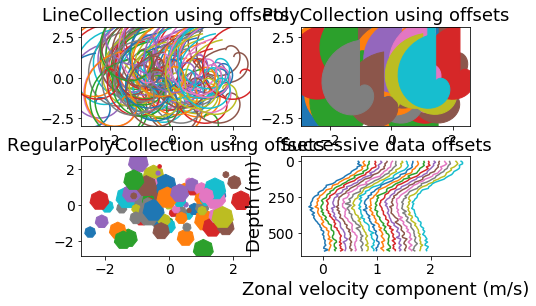

In [220]:
import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms
import numpy as np

nverts = 50
npts = 100

# Make some spirals
r = np.arange(nverts)
theta = np.linspace(0, 2*np.pi, nverts)
xx = r * np.sin(theta)
yy = r * np.cos(theta)
spiral = list(zip(xx, yy))

# Make some offsets
rs = np.random.RandomState([12345678])
xo = rs.randn(npts)
yo = rs.randn(npts)
xyo = list(zip(xo, yo))

# Make a list of colors cycling through the default series.
colors = [colors.to_rgba(c)
          for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]

fig, axes = plt.subplots(2, 2)
fig.subplots_adjust(top=0.92, left=0.07, right=0.97,
                    hspace=0.3, wspace=0.3)
((ax1, ax2), (ax3, ax4)) = axes  # unpack the axes

col = collections.LineCollection([spiral], offsets=xyo,
                                 transOffset=ax1.transData)
trans = fig.dpi_scale_trans + transforms.Affine2D().scale(1.0/72.0)
col.set_transform(trans)  # the points to pixels transform
# Note: the first argument to the collection initializer
# must be a list of sequences of x,y tuples; we have only
# one sequence, but we still have to put it in a list.
ax1.add_collection(col, autolim=True)
# autolim=True enables autoscaling.  For collections with
# offsets like this, it is neither efficient nor accurate,
# but it is good enough to generate a plot that you can use
# as a starting point.  If you know beforehand the range of
# x and y that you want to show, it is better to set them
# explicitly, leave out the autolim kwarg (or set it to False),
# and omit the 'ax1.autoscale_view()' call below.

# Make a transform for the line segments such that their size is
# given in points:
col.set_color(colors)

ax1.autoscale_view()  # See comment above, after ax1.add_collection.
ax1.set_title('LineCollection using offsets')


# The same data as above, but fill the curves.
col = collections.PolyCollection([spiral], offsets=xyo,
                                 transOffset=ax2.transData)
trans = transforms.Affine2D().scale(fig.dpi/72.0)
col.set_transform(trans)  # the points to pixels transform
ax2.add_collection(col, autolim=True)
col.set_color(colors)


ax2.autoscale_view()
ax2.set_title('PolyCollection using offsets')

# 7-sided regular polygons

col = collections.RegularPolyCollection(7,
                                        sizes=np.fabs(xx) * 10.0, offsets=xyo,
                                        transOffset=ax3.transData)
trans = transforms.Affine2D().scale(fig.dpi / 72.0)
col.set_transform(trans)  # the points to pixels transform
ax3.add_collection(col, autolim=True)
col.set_color(colors)
ax3.autoscale_view()
ax3.set_title('RegularPolyCollection using offsets')


# Simulate a series of ocean current profiles, successively
# offset by 0.1 m/s so that they form what is sometimes called
# a "waterfall" plot or a "stagger" plot.

nverts = 60
ncurves = 20
offs = (0.1, 0.0)

yy = np.linspace(0, 2*np.pi, nverts)
ym = np.amax(yy)
xx = (0.2 + (ym - yy)/ym)**2 * np.cos(yy - 0.4)*0.5
segs = []
for i in range(ncurves):
    xxx = xx + 0.02*rs.randn(nverts)
    curve = list(zip(xxx, yy*100))
    segs.append(curve)

col = collections.LineCollection(segs, offsets=offs)
ax4.add_collection(col, autolim=True)
col.set_color(colors)
ax4.autoscale_view()
ax4.set_title('Successive data offsets')
ax4.set_xlabel('Zonal velocity component (m/s)')
ax4.set_ylabel('Depth (m)')
# Reverse the y-axis so depth increases downward
ax4.set_ylim(ax4.get_ylim()[::-1])


plt.show()

In [177]:
def compute_regional_stats(vars_to_retrieve = 'wetso4', 
                           OBS_network = 'GAWTADsubsetAasEtAl', 
                           list_model_ID = ['OsloCTM3v1.01-met2010_AP3-CTRL', 
                                            'CAM5-ATRAS_AP3-CTRL',
                                            'GFDL-AM4-met2010_AP3-CTRL', 
                                            'GFDL-AM4-fSST_AP3-CTRL'],
                           add_yearly = 'mean',
                           start = 2010,
                           bias = True, 
                           rmse = True, 
                           region = None):
    """
    Parameters
    ----------
    vars_to_retrieve : str
            'wetso4', 
    OBS_network : str
        'GAWTADsubsetAasEtAl', 
    list_model_ID : list[str]
        ['OsloCTM3v1.01-met2010_AP3-CTRL', 'CAM5-ATRAS_AP3-CTRL'], 
    start : int,
        defalt = 2010,
    bias : bool
        default True 
    rmse : bool, 
        default True, 
    region : str
    
    Returns 
    ------------------
    df : DataFrame 
    
    Notes
    ----------------------------
    Available regions :
    ['WORLD',
     'EUROPE',
     'ASIA',
     'AUSTRALIA',
     'CHINA',
     'INDIA',
     'NAFRICA',
     'SAFRICA',
     'SAMERICA',
     'NAMERICA']

    """    
    ungridded_data    = ReadUngridded().read(datasets_to_read = OBS_network, vars_to_retrieve = vars_to_retrieve)
    
    # TODO collocated dataobject can now done by collocated data object, much less stuff to filter by (faster).
    
    #if region is not None:
    #    f              = Filter(region=region)
    #    ungridded_data = f(ungridded_data)
        
    station_names     = ungridded_data.station_name
    list_gridded_data = [pya.io.ReadGridded(ID).read(vars_to_retrieve = [vars_to_retrieve], start = start)[0] 
                         for ID in list_model_ID ]
    list_colocate = [pya.colocation.colocate_gridded_ungridded(gridded_data, 
                                                           ungridded_data, 
                                                           ts_type='monthly')                     
                     for gridded_data in list_gridded_data]
    
    # Possible to retrieve ts type of obeservation 0
    stats = {}
    # need world to 
    for i, coloc in enumerate(list_colocate):
        stats[list_model_ID[i]] = {}
        for region in ['WORLD', 'EUROPE','ASIA','AUSTRALIA', 'CHINA','INDIA', 'NAFRICA','SAFRICA', 'SAMERICA','NAMERICA']:
            filtered = coloc.apply_latlon_filter(region_id = region)
            print(filtered)
            num_stat = filtered.coords_with_data
            dict_stats = filtered.calc_statistics()
            #print(dict_stats)
            dict_stats.update({'num_stations': num_stat}) 
            stats[list_model_ID[i]][region] = dict_stats
    return stats

In [178]:
stats = compute_regional_stats(vars_to_retrieve = 'wetso4', 
                           OBS_network = 'GAWTADsubsetAasEtAl', 
                           list_model_ID = ['OsloCTM3v1.01-met2010_AP3-CTRL', 
                                            'CAM5-ATRAS_AP3-CTRL'], 
                                            #'GFDL-AM4-met2010_AP3-CTRL', 
                                            #'GFDL-AM4-fSST_AP3-CTRL'],
                           add_yearly = 'mean',
                           start = 2010,)

/home/hannas/Desktop/pyaerocom/pyaerocom/io/iris_io.py:415: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=TS_TYPE_TO_PANDAS_FREQ[ts_type])
Setting wetso4 outlier lower lim: 0.00
Setting wetso4 outlier upper lim: 10000.00
Interpolating data of shape (12, 80, 160). This may take a while.
/home/hannas/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/hannas/anaconda3/lib/python3.7/site-packages/iris/analysis/_scipy_interpolate.py:290: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as


Pyaerocom ColocatedData
-----------------------
Data: <xarray.DataArray 'wetso4' (data_source: 2, time: 12, station_name: 316)>
array([[[         nan, 8.948091e-12, ..., 4.474046e-11, 4.474046e-12],
        [1.201201e-11,          nan, ..., 6.563265e-11, 6.191760e-12],
        ...,
        [1.329164e-11, 1.618113e-11, ..., 7.859407e-11, 4.623181e-12],
        [1.029031e-11, 9.507347e-12, ..., 4.697748e-11, 3.355534e-12]],

       [[1.101474e-11, 1.506232e-11, ..., 3.294521e-11, 8.714301e-12],
        [1.617417e-11, 1.690011e-11, ..., 5.388155e-11, 2.028353e-11],
        ...,
        [1.241212e-11, 2.067017e-11, ..., 4.199042e-11, 9.995354e-12],
        [1.188433e-11, 1.755087e-11, ..., 2.521044e-11, 1.032021e-11]]])
Coordinates:
  * data_source   (data_source) <U30 'GAWTADsubsetAasEtAl' 'OsloCTM3v1.01-met2010_AP3-CTRL'
    var_name      (data_source) <U6 'wetso4' 'wetso4'
    var_units     (data_source) <U10 'kg m-2 s-1' 'kg m-2 s-1'
    ts_type_src   (data_source) <U7 'monthly' 'mont


Pyaerocom ColocatedData
-----------------------
Data: <xarray.DataArray 'wetso4' (data_source: 2, time: 12, station_name: 0)>
array([], shape=(2, 12, 0), dtype=float64)
Coordinates:
  * data_source   (data_source) <U19 'GAWTADsubsetAasEtAl' 'CAM5-ATRAS_AP3-CTRL'
    var_name      (data_source) <U6 'wetso4' 'wetso4'
    var_units     (data_source) <U10 'kg m-2 s-1' 'kg m-2 s-1'
    ts_type_src   (data_source) <U7 'monthly' 'monthly'
  * time          (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2010-12-01
  * station_name  (station_name) <U63 
    latitude      (station_name) float64 
    longitude     (station_name) float64 
    altitude      (station_name) float64 
Attributes:
    data_source:       ['GAWTADsubsetAasEtAl', 'CAM5-ATRAS_AP3-CTRL']
    var_name:          ['wetso4', 'wetso4']
    ts_type:           monthly
    filter_name:       SAMERICA-wMOUNTAINS
    ts_type_src:       ['monthly', 'monthly']
    start_str:         20100101
    stop_str:          20101231
    var_uni

In [240]:
# stats

In [180]:
import seaborn as sns

In [288]:
df = pd.DataFrame.from_dict(stats)
#df = (df-df.mean())/df.std()

In [289]:
df = pd.concat({k: pd.DataFrame(v).T for k, v in stats.items()}, axis=0)

In [290]:
df

R  R_kendall  R_spearman  \
CAM5-ATRAS_AP3-CTRL            WORLD      0.439949   0.488811    0.668131   
                               EUROPE     0.486376   0.404062    0.567137   
                               ASIA       0.274521   0.365739    0.499508   
                               AUSTRALIA       NaN        NaN         NaN   
                               CHINA      0.153765   0.358461    0.443711   
                               INDIA      0.395021   0.343661    0.484687   
                               NAFRICA    0.111984   0.131594    0.185038   
                               SAFRICA         NaN        NaN         NaN   
                               SAMERICA        NaN        NaN         NaN   
                               NAMERICA   0.633995   0.530775    0.726065   
OsloCTM3v1.01-met2010_AP3-CTRL WORLD      0.604094   0.506013    0.684607   
                               EUROPE     0.573396   0.436335    0.608871   
                               ASIA       0.496538   0.395128    0.557461   
                               AUSTRALIA       NaN        NaN         NaN   
                               CHINA      0.509701   0.443560    0.599167   
                               INDIA      0.287644   0.326060    0.487323   
                               NAFRICA    0.459227   0.320277    0.449040   
                               SAFRICA         NaN        NaN         NaN   
                               SAMERICA        NaN        NaN         NaN   
                               NAMERICA   0.643338   0.533158    0.723031   

                                             data_mean      data_std  \
CAM5-ATRAS_AP3-CTRL            WORLD      3.141271e-11  5.018101e-11   
                               EUROPE     3.008709e-11  3.157894e-11   
                               ASIA       1.209218e-10  1.893539e-10   
                               AUSTRALIA           NaN           NaN   
                               CHINA      2.145614e-10  2.729316e-10   
                               INDIA      7.409971e-11  8.563198e-11   
                               NAFRICA    1.648878e-11  1.465755e-11   
                               SAFRICA             NaN           NaN   
                               SAMERICA            NaN           NaN   
                               NAMERICA   2.661734e-11  2.174734e-11   
OsloCTM3v1.01-met2010_AP3-CTRL WORLD      1.627823e-11  1.404646e-11   
                               EUROPE     1.831768e-11  1.105397e-11   
                               ASIA       4.274041e-11  4.030673e-11   
                               AUSTRALIA           NaN           NaN   
                               CHINA      6.155913e-11  5.046387e-11   
                               INDIA      3.376930e-11  2.948105e-11   
                               NAFRICA    7.903444e-12  5.011975e-12   
                               SAFRICA             NaN           NaN   
                               SAMERICA            NaN           NaN   
                               NAMERICA   1.427057e-11  9.342695e-12   

                                               fge      mnmb       nmb  \
CAM5-ATRAS_AP3-CTRL            WORLD      0.679258  0.390378  0.461016   
                               EUROPE     0.627312  0.218005  0.295021   
                               ASIA       1.158851  0.633553  0.790424   
                               AUSTRALIA       NaN       NaN       NaN   
                               CHINA      1.113800  0.820966  0.980746   
                               INDIA      1.201366  0.576620  0.663566   
                               NAFRICA    0.801545  0.196478  0.167456   
                               SAFRICA         NaN       NaN       NaN   
                               SAMERICA        NaN       NaN       NaN   
                               NAMERICA   0.658623  0.431372  0.442505   
OsloCTM3v1.01-met2010_AP3-CTRL WORLD      0.590526  0.002855 -0.253817   
                              

In [296]:
df = df.swaplevel(0,1).unstack()

In [190]:
#df = df.swapaxes(0,1)

In [191]:
#df = df.stack()

In [192]:
#df = df.swapaxes(0,1)

In [193]:
#idx = df.index
#cols = df.c

In [194]:
#df_to_heatmap?

In [197]:
#ax_ctm3 = df_to_heatmap(, cbar = True, num_digits=3)

In [297]:
#df['num_stations'].values

In [298]:
colors = sns.diverging_palette(220, 20, n=7)

In [299]:
df

R                                 \
          CAM5-ATRAS_AP3-CTRL OsloCTM3v1.01-met2010_AP3-CTRL   
WORLD                0.439949                       0.604094   
EUROPE               0.486376                       0.573396   
ASIA                 0.274521                       0.496538   
AUSTRALIA                 NaN                            NaN   
CHINA                0.153765                       0.509701   
INDIA                0.395021                       0.287644   
NAFRICA              0.111984                       0.459227   
SAFRICA                   NaN                            NaN   
SAMERICA                  NaN                            NaN   
NAMERICA             0.633995                       0.643338   

                    R_kendall                                 \
          CAM5-ATRAS_AP3-CTRL OsloCTM3v1.01-met2010_AP3-CTRL   
WORLD                0.488811                       0.506013   
EUROPE               0.404062                       0.436335   
ASIA                 0.365739                       0.395128   
AUSTRALIA                 NaN                            NaN   
CHINA                0.358461                       0.443560   
INDIA                0.343661                       0.326060   
NAFRICA              0.131594                       0.320277   
SAFRICA                   NaN                            NaN   
SAMERICA                  NaN                            NaN   
NAMERICA             0.530775                       0.533158   

                   R_spearman                                 \
          CAM5-ATRAS_AP3-CTRL OsloCTM3v1.01-met2010_AP3-CTRL   
WORLD                0.668131                       0.684607   
EUROPE               0.567137                       0.608871   
ASIA                 0.499508                       0.557461   
AUSTRALIA                 NaN                            NaN   
CHINA                0.443711                       0.599167   
INDIA                0.484687                       0.487323   
NAFRICA              0.185038                       0.449040   
SAFRICA                   NaN                            NaN   
SAMERICA                  NaN                            NaN   
NAMERICA             0.726065                       0.723031   

                    data_mean                                 \
          CAM5-ATRAS_AP3-CTRL OsloCTM3v1.01-met2010_AP3-CTRL   
WORLD            3.141271e-11                   1.627823e-11   
EUROPE           3.008709e-11                   1.831768e-11   
ASIA             1.209218e-10                   4.274041e-11   
AUSTRALIA                 NaN                            NaN   
CHINA            2.145614e-10                   6.155913e-11   
INDIA            7.409971e-11                   3.376930e-11   
NAFRICA          1.648878e-11                   7.903444e-12   
SAFRICA                   NaN                            NaN   
SAMERICA                  NaN                            NaN   
NAMERICA         2.661734e-11                   1.427057e-11   

                     data_std                                 ...  \
          CAM5-ATRAS_AP3-CTRL OsloCTM3v1.01-met2010_AP3-CTRL  ...   
WORLD            5.018101e-11                   1.404646e-11  ...   
EUROPE           3.157894e-11                   1.105397e-11  ...   
ASIA             1.893539e-10                   4.030673e-11  ...   
AUSTRALIA                 NaN                            NaN  ...   
CHINA            2.729316e-10                   5.046387e-11  ...   
INDIA            8.563198e-11                   2.948105e-11  ...   
NAFRICA          1.465755e-11                   5.011975e-12  ...   
SAFRICA                   NaN                            NaN  ...   
SAMERICA                  NaN                            NaN  ...   
NAMERICA         2.174734e-11                   9.342695e-12  ...   

                    num_valid                                 \
          CAM5-ATRAS_AP3-CTRL OsloCTM3v1.01-met2010_AP3-CTR

In [300]:
test = df['R_spearman']

In [301]:
models = test.index.values

In [302]:
regions = test.columns.values

In [303]:
pd.MultiIndex.from_product([test.index.values, test.columns.values], names=['model', 'region'])

MultiIndex(levels=[['ASIA', 'AUSTRALIA', 'CHINA', 'EUROPE', 'INDIA', 'NAFRICA', 'NAMERICA', 'SAFRICA', 'SAMERICA', 'WORLD'], ['CAM5-ATRAS_AP3-CTRL', 'OsloCTM3v1.01-met2010_AP3-CTRL']],
           codes=[[9, 9, 3, 3, 0, 0, 1, 1, 2, 2, 4, 4, 5, 5, 7, 7, 8, 8, 6, 6], [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]],
           names=['model', 'region'])

In [307]:
idxeses = pd.MultiIndex.from_product([test.index.values, test.columns.values], names=['model', 'region']).codes

In [310]:
len(regions[idxeses[1]])

20

In [311]:
len(models[idxeses[0]])

20

In [312]:
df['num_stations'].values.reshape(-1)

array([316., 316.,  63.,  63.,  14.,  14.,   0.,   0.,   5.,   5.,   8.,
         8.,   6.,   6.,   0.,   0.,   0.,   0., 236., 236.])

In [313]:
df['R_spearman'].values.reshape(-1)

array([0.66813104, 0.68460698, 0.56713653, 0.6088713 , 0.49950796,
       0.55746085,        nan,        nan, 0.44371141, 0.59916723,
       0.48468664, 0.48732281, 0.18503784, 0.4490403 ,        nan,
              nan,        nan,        nan, 0.72606521, 0.72303065])

In [314]:
sizes  = df['num_stations'].values.reshape(-1)
values = df['R_spearman'].values.reshape(-1)

In [315]:
df = pd.DataFrame.from_dict({'region': regions[idxeses[1]], 
                            'model': models[idxeses[0]], 
                            'size':sizes, 
                            'values':values})

In [435]:
def heatmap(x, y, values, figsize = (15,10), **kwargs):
    """ From Augustin 
    
    **kwargs, color, palette, color_range, size, size_range 
    
    """
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors)

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(values), max(values) # Range of values that will be mapped to the palette, i.e. min and max possible correlation
    
    print(min(color), max(color) )
    
    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max-1 - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
        
    if 'x_order' in kwargs:
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
        
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs:
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
        
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    #new figure
    plt.figure(figsize=figsize)
   
    plot_grid = plt.GridSpec(1, 14+3, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    print(plot_grid)
    ax = plt.subplot(plot_grid[:,:-3]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker',
         'x_order', 'y_order', 'colorbar', 'title'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size],
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
       
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        if kwargs['colorbar']:
            print('enters')
            ax = plt.subplot(plot_grid[:,-1:]) # Use the rightmost column of the plot
            #plot pvalues
            """
            for i, pval in enumerate(np.arange(min(values), max(values), 4)):
                #  ms = pval2size(pval)
                msize = 0.99**i*1000
                plt.plot(1.0,0.8*i+0.3,'o', markersize=msize, color='black', mfc='none')
                if i==3:
                    txt = '< 0.1'
                if i==2:
                    txt = '< 0.2'
                if i==1:
                    txt = '< 0.4'
                if i==0:
                    txt = '> 0.5'
                plt.text(2.1,0.8*i+0.2, txt, transform=ax.transData, fontsize=13)
            ax.set_ylim([-1,4])
            ax.set_xlim([0,2])
            ax.axes.get_yaxis().set_visible(False)
            ax.axes.get_xaxis().set_visible(False)
            ax.set_facecolor('white')
            plt.title('p-val',x=1.15,y=0.8)
            ax.margins(0)
           """
           
            ax    = plt.subplot(plot_grid[:,-3:-2]) # Use the rightmost column of the plot
            col_x = [1.5]*len(palette) # Fixed x coordinate for the bars
            bar_y = np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

            bar_height = bar_y[1] - bar_y[0]
            ax.barh(
                y=bar_y,
                width=[1.5]*len(palette), # Make bars 5 units wide
                left=col_x, # Make bars start at 0
                height=bar_height,
                color=palette,
                linewidth=0
            )
            ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
            ax.grid(False) # Hide grid
            ax.set_facecolor('white') # Make background white
            ax.set_xticks([]) # Remove horizontal ticks
            ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
            ax.yaxis.tick_right() # Show vertical ticks on the right
            ax.tick_params(length=0,pad=3,grid_alpha=0,grid_zorder=0)
            plt.title('%/yr',x=1.0,y=0.8)
            ax.margins(0.4)
            plt.draw()
            #add a + sign to positive trends
            ylabs = ax.get_yticklabels()
            for i, ylab in enumerate(ylabs):
                yl = ylab.get_text()
                if yl[0]!='−' and yl[0]!='0':
                    yl='+'+yl
                ylabs[i].set_text(yl)
            ax.set_yticklabels(ylabs)
             
    if kwargs['title']:
        axs = plt.subplot(plot_grid[:,:-3]) # Use the left 14/15ths of the grid for the main plot
        plt.title(kwargs['title'])

    return ax

In [436]:
df.head()

,region,model,size,values
0,CAM5-ATRAS_AP3-CTRL,NAMERICA,316.0,0.668131
1,OsloCTM3v1.01-met2010_AP3-CTRL,NAMERICA,316.0,0.684607
2,CAM5-ATRAS_AP3-CTRL,AUSTRALIA,63.0,0.567137
3,OsloCTM3v1.01-met2010_AP3-CTRL,AUSTRALIA,63.0,0.608871
4,CAM5-ATRAS_AP3-CTRL,WORLD,14.0,0.499508


In [437]:
#sns.diverging_palette?

1 1
GridSpec(1, 17)
enters


/home/hannas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:168: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


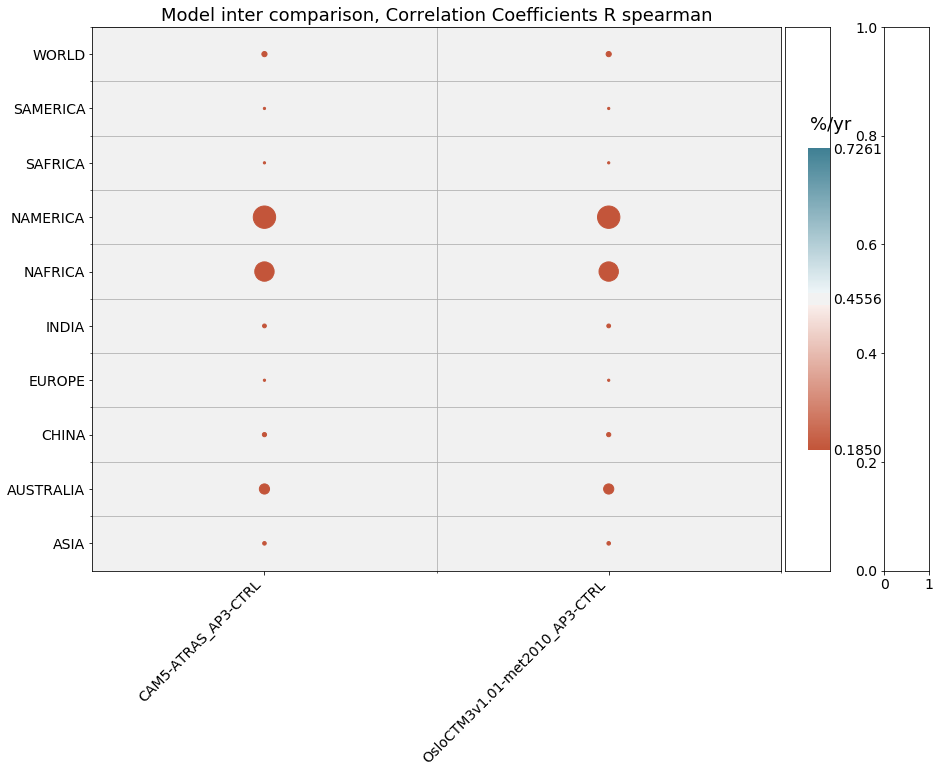

In [438]:
#fig, axes = plt.figure(figsize = (20,12))
ax = heatmap(x = df['region'].values, 
             y = df['model'].values, 
             values = df['values'].values,
             size = df['size'].values, 
             title = 'Model inter comparison, Correlation Coefficients R spearman',
             palette = sns.diverging_palette(20, 220, n=256), 
             marker = 'o', colorbar = True)
#ax.legend()

In [434]:
ax_ctm3 = df_to_heatmap(df['R_spearman'], cbar = True, num_digits=3)

ax_ctm3.set_title('Spreaman correlation coefficient')
#ax_ctm3.scatter(, df['num_stations'].values,  c="crimson", s=100)

KeyError: 'R_spearman'

In [ ]:
ax_ctm3 = df_to_heatmap(df['fge'], cbar = True, num_digits=3)

# Save for later 

In [ ]:
vars_to_retrieve = 'wetso4'
OBS_network = 'GAWTADsubsetAasEtAl'
list_model_ID = ['OsloCTM3v1.01-met2010_AP3-CTRL', 'CAM5-ATRAS_AP3-CTRL']
add_yearly = 'mean'
start = 2010
bias = True 
rmse = True
region = 'NAMERICA'

ungridded_data    = ReadUngridded().read(datasets_to_read = OBS_network, vars_to_retrieve = vars_to_retrieve)

# TODO collocated dataobject can now done by collocated data object, much less stuff to filter by (faster).

if region is not None:
    f              = Filter(region=region)
    ungridded_data = f(ungridded_data)

station_names     = ungridded_data.station_name # Is this used anymore. 
list_gridded_data = [pya.io.ReadGridded(ID).read(vars_to_retrieve = [vars_to_retrieve], start = start)[0] 
                     for ID in list_model_ID ]


# calc_statistics() -- returns one value for.

# Possible to retrieve ts type of obeservation 
list_colocate = [pya.colocation.colocate_gridded_ungridded(gridded_data, 
                                                           ungridded_data, 
                                                           ts_type='monthly') # calc_statistics()
                for gridded_data in list_gridded_data]

#example_stats = list_colocate[0]

# call merged : raw, bias : Bias, rmse : RMSE 
def fix_df(df):
    df = df.unstack('data_source').swaplevel().unstack('station_name')
    df2 = df['wetso4']
    df2.columns = df2.columns.swaplevel(0,1)
    df2.sort_index(axis = 1, level = (0, 1), inplace = True)
    return df2

dataframes = [ coloc.data.to_dataframe().drop(columns=['var_name', 'var_units','ts_type_src','altitude', 
                                                       'latitude', 'longitude']) for coloc in list_colocate ]
dataframes = [fix_df(df) for df in dataframes]

seasonal_means = [coloc.data.groupby('time.season').mean(dim = 'time', skipna = True) for coloc in list_colocate]
df_seasons = [fix_df(seasonal_mean.to_dataframe()) for seasonal_mean in seasonal_means]

for i in range(len(dataframes)):
    # Append yearly mean
    dataframes[i]       = dataframes[i].append( dataframes[i].mean(axis = 0), ignore_index = True)
    # Appends seasonal averages
    dataframes[i]       = dataframes[i].append( df_seasons[i], ignore_index = True)
    # Updates index 
    dataframes[i].index = np.concatenate([np.arange(12), ['year', 'DJF', 'MAM', 'JJA', 'SON']])

lala = pd.concat(dataframes, axis = 1) # Merged dataframes containing diffent models.
lala.sort_index(axis = 1, level = (0, 1), inplace = True) # Sort index
df = lala.loc[:, ~lala.columns.duplicated()] # Removes duplicates
# In this case the obsevations are duplicated, since they are present in both model comparison.
df_to_heatmap(df.iloc[:, :10]['Abington (CT15)'], num_digits=12)

In [ ]:
 example_stats.data['Abington (CT15)']

# Example from __init__( ) in colocated data. 

In [ ]:
import matplotlib.pyplot as plt
import pyaerocom as pya
plt.close('all')
obsdata = pya.io.ReadUngridded().read('AeronetSunV3Lev2.daily', 'od550aer')
modeldata = pya.io.ReadGridded('ECMWF_CAMS_REAN').read_var('od550aer', start=2010)

coldata1 = pya.colocation.colocate_gridded_ungridded(modeldata, obsdata, 
                                                    ts_type='monthly',
                                                    start=2010,
                                                    var_outlier_ranges={'od550aer':[0,10]},
                                                    filter_name='WORLD-noMOUNTAINS',
                                                    remove_outliers=True, 
                                                    colocate_time=False)

sat = pya.io.ReadGridded('MODIS6.aqua').read_var('od550aer', start=2010)

coldata2 = pya.colocation.colocate_gridded_gridded(modeldata, sat, 
                                                   ts_type='monthly',
                                                   regrid_res_deg=10)

sat_namerica = coldata2.apply_latlon_filter(region_id='NAMERICA')
sat_namerica.plot_scatter()
sat_namerica.plot_coordinates()

coldata1.plot_scatter()

stats = {}
for region_id in pya.region.get_all_default_region_ids():
    filtered = coldata1.apply_latlon_filter(region_id=region_id)
    stats[region_id] = filtered.calc_statistics()
print('AERONET')    
for r, s in stats.items():
    if s['num_valid'] == 0:
        print('No data in region {}'.format(r))
    else:
        print('{}: NMB={:.3f} (R={:.2f})'.format(r, s['nmb']*100, s['R']))

stats = {}
for region_id in pya.region.get_all_default_region_ids():
    filtered = coldata2.apply_latlon_filter(region_id=region_id)
    stats[region_id] = filtered.calc_statistics()
print('MODIS')    
for r, s in stats.items():
    if s['num_valid'] == 0:
        print('No data in region {}'.format(r))
    else:
        print('{}: NMB={:.3f} (R={:.2f})'.format(r, s['nmb']*100, s['R']))


In [ ]:
list_colocate[0].calc_statistics() # Statistics of a ensamble of data. 

In [ ]:
stats = {}
for region_id in pya.region.get_all_default_region_ids():
    filtered = coldata1.apply_latlon_filter(region_id=region_id)
    stats[region_id] = list_colocate[0].calc_statistics()

In [ ]:
df.rename(columns={"GAWTADsubsetAasEtAl": "obs", 
                   "CAM5-ATRAS_AP3-CTRL": "CAM5", 
                   "OsloCTM3v1.01-met2010_AP3-CTRL": "OsloCTM3"}, inplace = True)

In [ ]:
station_names[:10] 

In [ ]:
for station_name in station_names:
    df[station_name]
    

In [ ]:
df_to_heatmap(df.iloc[:, :10]['Abington (CT15)'], num_digits=12, cbar = True)

In [ ]:
calc_statistics?

In [ ]:
df.columns

In [ ]:
#df.sort_index(axis = 1, level = (0, 1), inplace = True)

In [ ]:
#df.append(df.sum().rename('Total')).assign(Total=lambda d:d.sum(1))

In [ ]:
#df = construct_df_model_intercomparison_to_observations(region = 'NAMERICA', bias = True, rmse = True)

In [ ]:
vars_to_retrieve = 'wetso4'
OBS_network = 'GAWTADsubsetAasEtAl'
list_model_ID = ['OsloCTM3v1.01-met2010_AP3-CTRL', 'CAM5-ATRAS_AP3-CTRL']
add_yearly = 'mean'
start = 2010
bias = True 
rmse = True 
region = None

In [ ]:
ungridded_data = ReadUngridded().read(datasets_to_read = OBS_network, vars_to_retrieve = vars_to_retrieve)

# TODO collocated dataobject can now done by collocated data object, much less stuff to filter by (faster).

station_names = ungridded_data.station_name
gridded_data  = pya.io.ReadGridded('OsloCTM3v1.01-met2010_AP3-CTRL').read(vars_to_retrieve = [vars_to_retrieve], start = start)[0]

# Possible to retrieve ts type of obeservation 
colocate = pya.colocation.colocate_gridded_ungridded(gridded_data, ungridded_data, ts_type='monthly')

In [ ]:
m.data

In [ ]:
stats = colocate.calc_statistics()

In [ ]:
stats

In [ ]:
ungridded_data    = ReadUngridded().read(datasets_to_read = OBS_network, vars_to_retrieve = vars_to_retrieve)

# TODO collocated dataobject can now done by collocated data object, much less stuff to filter by (faster).
if region is not None:
    f              = Filter(region=region)
    ungridded_data = f(ungridded_data)

station_names     = ungridded_data.station_name
list_gridded_data = [pya.io.ReadGridded(ID).read(vars_to_retrieve = [vars_to_retrieve], start = start)[0] 
                     for ID in list_model_ID ]

# Possible to retrieve ts type of obeservation 
list_colocate = [pya.colocation.colocate_gridded_ungridded(gridded_data, ungridded_data, ts_type='monthly')
                for gridded_data in list_gridded_data]

# call merged : raw, bias : Bias, rmse : RMSE 
def fix_df(df):
    df = df.unstack('data_source').swaplevel().unstack('station_name')
    df2 = df['wetso4']
    df2.columns = df2.columns.swaplevel(0,1)
    df2.sort_index(axis = 1, level = (0, 1), inplace = True)
    return df2

dataframes = [ coloc.data.to_dataframe().drop(columns=['var_name', 'var_units','ts_type_src','altitude', 
                                                       'latitude', 'longitude']) for coloc in list_colocate ]

In [ ]:
list_colocate[0]

In [ ]:
#list_colocate[0].data

In [ ]:
seasonal_means = [ coloc.data.groupby('time.season').mean(dim='time') for coloc in list_colocate ]

In [ ]:
df = dataframes[0]
coloc_season = seasonal_means[0]

In [ ]:
fix_df(seasonal_means[0].to_dataframe())

In [ ]:
fix_df(df).index 

In [ ]:
coloc_season

In [ ]:
coloc_season = seasonal_means[1]

In [ ]:
coloc_season.values

In [ ]:
coloc_season['season'].values

In [ ]:
for name, g in coloc_season:
    print(g)
#coloc_season.DFJ